In [1]:
import sys
sys.path.append('../')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from fb_gp import saas_fbgp
import numpy as np
import time
import jax.numpy as jnp
from jax import random,vmap, grad
from jax.lax import while_loop
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from acquisition import EI, IPV, optim_scipy_bh
import scipy.optimize
from scipy.stats import qmc
from jaxns import NestedSampler
import corner
from nested_sampler import nested_sampling_jaxns, nested_sampling_Dy
from getdist import plots,MCSamples,loadMCSamples


matplotlib.rc('font', size=16,family='serif')
matplotlib.rc('legend', fontsize=16)

### EI test

[[0.01795472 0.0032797  0.00629377 0.00188088]
 [0.0032797  0.01140048 0.00206096 0.00450058]
 [0.00629377 0.00206096 0.0193845  0.00201846]
 [0.00188088 0.00450058 0.00201846 0.01147207]]
(8, 4) (8, 1)
Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:01<00:00, 1015.91it/s, 7 steps of size 4.17e-01. acc. prob=0.70]
INFO:[GP]: MCMC elapsed time: 2.62s



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]      1.86      2.77      0.99      0.03      4.05     40.01      0.98
_kernel_inv_length_sq[1]     65.57    212.36      1.27      0.09    193.82     38.65      0.97
_kernel_inv_length_sq[2]    135.91    702.59      2.43      0.28     15.45     31.02      1.00
_kernel_inv_length_sq[3]      2.96      2.80      2.00      0.23      6.31     42.14      0.99
        kernel_length[0]      1.87      1.62      1.32      0.22      3.25     35.10      0.98
        kernel_length[1]      1.16      1.10      0.82      0.07      2.32     26.85      0.98
        kernel_length[2]      1.02      1.40      0.75      0.03      1.24     35.09      1.02
        kernel_length[3]      1.23      1.33      0.90      0.18      1.77     32.40      0.97
            kernel_tausq      1.88      2.95      0.56      0.04      5.89     38.40      0.97
              kernel_var      8.19      7.27     

Text(0, 0.5, '$x_4$')

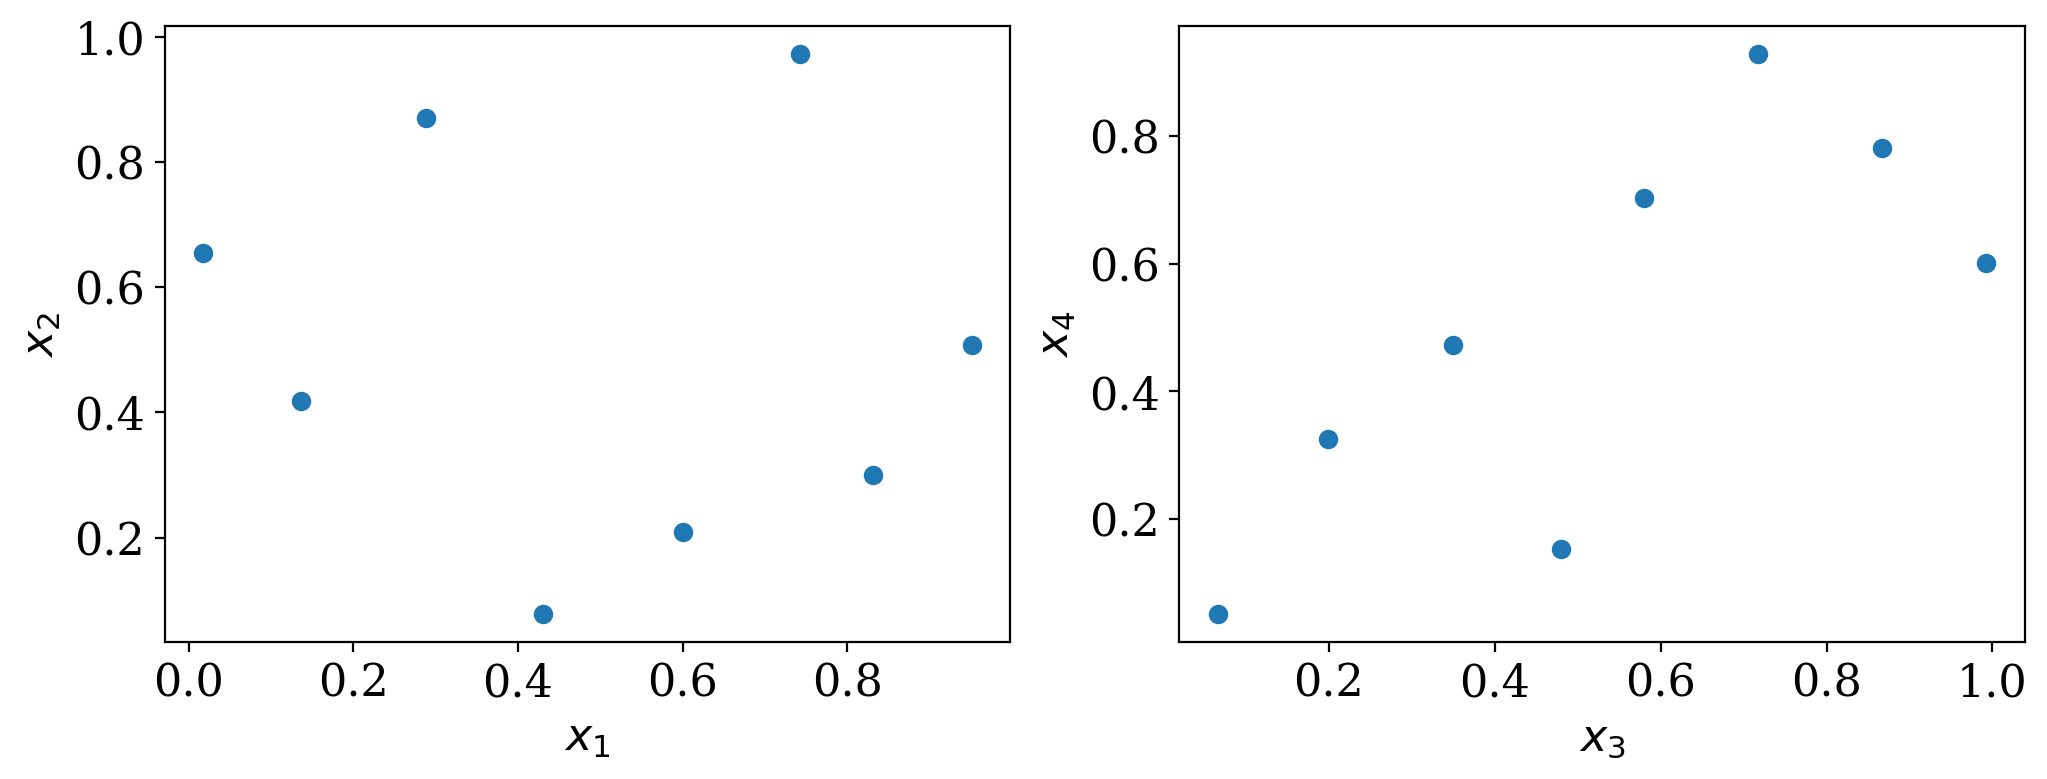

In [2]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 8
ndim = 4
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)
f_mean = np.array([0.41,0.63,0.58,0.45])[:ndim]
cov1 = 0.1*np.eye(ndim) + 0.2*np.random.uniform(0.,0.5,(ndim,ndim))
cov = 0.05*(cov1 + np.transpose(cov1))
print(cov)

from scipy.stats import multivariate_normal

mnorm =  multivariate_normal(mean = f_mean,cov = cov)

f = lambda x: mnorm.logpdf(x).reshape(-1,1) # -0.5*np.sum((x - f_mean)**2,axis=-1,keepdims=True)/ f_std**2 

train_y = f(train_x)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-6)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.scatter(train_x[:,0],train_x[:,1])
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
ax2.scatter(train_x[:,2],train_x[:,3])
ax2.set_xlabel(r'$x_3$')
ax2.set_ylabel(r'$x_4$')

In [3]:
nsteps = 16 # 32
mc_points_size = 16
start = time.time()
for i in range(nsteps):
    samples, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
    print(f"LogZ info :"+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
    size = len(samples)
    mc_points = samples[::int(size/mc_points_size),:]
    acq_func = EI(gp,gp.train_y.max()) # IPV(gp,mc_points)
    grad_fn = grad(acq_func)
    # print(ndim)
    x0 =  np.random.uniform(0,1,ndim)
    # print(x0.shape)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/4,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    # next_val = results.fun 
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x = jnp.atleast_2d(results.x)
    next_y = f((next_x)) 
    # print(next_y.shape)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    gp = saas_fbgp(train_x,train_y,noise=1e-6)
    gp.fit(rng_key,warmup_steps=256,num_samples=256,thinning=16,verbose=False) # change rng key?
    print(f"----------------------Step {i+1} complete----------------------\n")


print(f"BO took {time.time() - start:.2f} s ")

INFO:[NS]: Nested Sampling took 3.82s
INFO:[NS]: jaxns did 17875 likelihood evaluations


LogZ info :logz_mean: = -4.0519, dlogz: = 0.2522, 


INFO:[AQ]: Acquisition optimization took 3.47 s


Next point at x = [0.         1.         0.93777013 0.        ] with acquisition function value = -0.3927404321183968


sample: 100%|██████████| 512/512 [00:00<00:00, 538.94it/s, 7 steps of size 4.01e-01. acc. prob=0.82] 
INFO:[GP]: MCMC elapsed time: 1.37s


----------------------Step 1 complete----------------------



INFO:[NS]: Nested Sampling took 1.97s
INFO:[NS]: jaxns did 21372 likelihood evaluations


LogZ info :logz_mean: = -4.1375, dlogz: = 0.2528, 


INFO:[AQ]: Acquisition optimization took 2.76 s


Next point at x = [0.         1.         0.         0.66760134] with acquisition function value = -0.3464373462602343


sample: 100%|██████████| 512/512 [00:00<00:00, 645.27it/s, 15 steps of size 2.68e-01. acc. prob=0.80]
INFO:[GP]: MCMC elapsed time: 1.13s


----------------------Step 2 complete----------------------



INFO:[NS]: Nested Sampling took 2.02s
INFO:[NS]: jaxns did 26182 likelihood evaluations


LogZ info :logz_mean: = -4.1800, dlogz: = 0.2713, 


INFO:[AQ]: Acquisition optimization took 3.32 s


Next point at x = [1.         1.         0.40329202 0.4776893 ] with acquisition function value = -0.19541352821072017


sample: 100%|██████████| 512/512 [00:00<00:00, 547.93it/s, 15 steps of size 3.30e-01. acc. prob=0.86]
INFO:[GP]: MCMC elapsed time: 1.32s


----------------------Step 3 complete----------------------



INFO:[NS]: Nested Sampling took 2.62s
INFO:[NS]: jaxns did 31815 likelihood evaluations


LogZ info :logz_mean: = -6.1371, dlogz: = 0.2756, 


INFO:[AQ]: Acquisition optimization took 4.15 s


Next point at x = [0.35436116 0.98551514 0.51670231 0.58395533] with acquisition function value = -0.23719452742113556


sample: 100%|██████████| 512/512 [00:00<00:00, 602.96it/s, 15 steps of size 1.85e-01. acc. prob=0.96]
INFO:[GP]: MCMC elapsed time: 1.19s


----------------------Step 4 complete----------------------



INFO:[NS]: Nested Sampling took 2.01s
INFO:[NS]: jaxns did 25055 likelihood evaluations


LogZ info :logz_mean: = -5.7436, dlogz: = 0.2646, 


INFO:[AQ]: Acquisition optimization took 3.29 s


Next point at x = [0.56320464 0.88412091 0.26072469 1.        ] with acquisition function value = -0.15087132118601906


sample: 100%|██████████| 512/512 [00:00<00:00, 620.86it/s, 7 steps of size 4.39e-01. acc. prob=0.86]
INFO:[GP]: MCMC elapsed time: 1.21s


----------------------Step 5 complete----------------------



INFO:[NS]: Nested Sampling took 2.51s
INFO:[NS]: jaxns did 32348 likelihood evaluations


LogZ info :logz_mean: = -5.8422, dlogz: = 0.2759, 


INFO:[AQ]: Acquisition optimization took 1.02 s


Next point at x = [1. 0. 0. 1.] with acquisition function value = -0.09863072710657823


sample: 100%|██████████| 512/512 [00:00<00:00, 666.64it/s, 7 steps of size 5.93e-01. acc. prob=0.85] 
INFO:[GP]: MCMC elapsed time: 1.12s


----------------------Step 6 complete----------------------



INFO:[NS]: Nested Sampling took 2.04s
INFO:[NS]: jaxns did 25829 likelihood evaluations


LogZ info :logz_mean: = -2.2152, dlogz: = 0.2533, 


INFO:[AQ]: Acquisition optimization took 3.02 s


Next point at x = [0.         0.10538013 0.36558838 0.        ] with acquisition function value = -0.19932280479138562


sample: 100%|██████████| 512/512 [00:00<00:00, 655.96it/s, 15 steps of size 4.95e-01. acc. prob=0.89]
INFO:[GP]: MCMC elapsed time: 1.13s


----------------------Step 7 complete----------------------



INFO:[NS]: Nested Sampling took 2.28s
INFO:[NS]: jaxns did 27514 likelihood evaluations


LogZ info :logz_mean: = -2.4619, dlogz: = 0.2574, 


INFO:[AQ]: Acquisition optimization took 3.03 s


Next point at x = [0.38800173 0.57006148 0.51937616 0.37624938] with acquisition function value = -0.12781369308377122


sample: 100%|██████████| 512/512 [00:00<00:00, 621.95it/s, 7 steps of size 4.10e-01. acc. prob=0.89] 
INFO:[GP]: MCMC elapsed time: 1.19s


----------------------Step 8 complete----------------------



INFO:[NS]: Nested Sampling took 2.11s
INFO:[NS]: jaxns did 28916 likelihood evaluations


LogZ info :logz_mean: = -0.2944, dlogz: = 0.2637, 


INFO:[AQ]: Acquisition optimization took 0.42 s


Next point at x = [1.         0.29846902 0.78960712 0.78792704] with acquisition function value = -9.308052024599011e-08


sample: 100%|██████████| 512/512 [00:00<00:00, 657.18it/s, 7 steps of size 5.40e-01. acc. prob=0.79]
INFO:[GP]: MCMC elapsed time: 1.19s


----------------------Step 9 complete----------------------



INFO:[NS]: Nested Sampling took 2.42s
INFO:[NS]: jaxns did 29676 likelihood evaluations


LogZ info :logz_mean: = -0.0783, dlogz: = 0.2567, 


INFO:[AQ]: Acquisition optimization took 1.99 s


Next point at x = [0.23671442 0.4713501  0.         0.        ] with acquisition function value = -0.005854579281142795


sample: 100%|██████████| 512/512 [00:00<00:00, 601.68it/s, 7 steps of size 4.57e-01. acc. prob=0.91]
INFO:[GP]: MCMC elapsed time: 1.31s


----------------------Step 10 complete----------------------



INFO:[NS]: Nested Sampling took 2.46s
INFO:[NS]: jaxns did 27906 likelihood evaluations


LogZ info :logz_mean: = -0.1308, dlogz: = 0.2626, 


INFO:[AQ]: Acquisition optimization took 3.82 s


Next point at x = [0.         0.43729801 0.19690628 0.44328048] with acquisition function value = -0.0019611979780156247


sample: 100%|██████████| 512/512 [00:00<00:00, 646.62it/s, 7 steps of size 5.51e-01. acc. prob=0.88] 
INFO:[GP]: MCMC elapsed time: 1.20s


----------------------Step 11 complete----------------------



INFO:[NS]: Nested Sampling took 2.85s
INFO:[NS]: jaxns did 26539 likelihood evaluations


LogZ info :logz_mean: = -0.0190, dlogz: = 0.2626, 


INFO:[AQ]: Acquisition optimization took 2.43 s


Next point at x = [0.75815111 0.74112689 1.         0.43310788] with acquisition function value = -0.012047576573046007


sample: 100%|██████████| 512/512 [00:00<00:00, 661.04it/s, 7 steps of size 6.56e-01. acc. prob=0.88] 
INFO:[GP]: MCMC elapsed time: 1.20s


----------------------Step 12 complete----------------------



INFO:[NS]: Nested Sampling took 2.38s
INFO:[NS]: jaxns did 29163 likelihood evaluations


LogZ info :logz_mean: = -0.1174, dlogz: = 0.2669, 


INFO:[AQ]: Acquisition optimization took 0.45 s


Next point at x = [1.         0.         0.24569357 0.        ] with acquisition function value = -3.288733216384201e-09


sample: 100%|██████████| 512/512 [00:00<00:00, 629.11it/s, 7 steps of size 5.92e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 1.20s


----------------------Step 13 complete----------------------



INFO:[NS]: Nested Sampling took 2.45s
INFO:[NS]: jaxns did 25819 likelihood evaluations


LogZ info :logz_mean: = -0.1953, dlogz: = 0.2642, 


INFO:[AQ]: Acquisition optimization took 0.44 s


Next point at x = [0.28064879 0.3559221  0.70503645 0.33816826] with acquisition function value = -1.0024930945950275e-08


sample: 100%|██████████| 512/512 [00:00<00:00, 645.82it/s, 7 steps of size 5.33e-01. acc. prob=0.93]
INFO:[GP]: MCMC elapsed time: 1.34s


----------------------Step 14 complete----------------------



INFO:[NS]: Nested Sampling took 2.41s
INFO:[NS]: jaxns did 29256 likelihood evaluations


LogZ info :logz_mean: = -0.2130, dlogz: = 0.2636, 


INFO:[AQ]: Acquisition optimization took 0.58 s


Next point at x = [0.94275421 0.22215513 0.90207495 0.07422113] with acquisition function value = -2.2838850760982298e-14


sample: 100%|██████████| 512/512 [00:00<00:00, 593.89it/s, 7 steps of size 6.36e-01. acc. prob=0.89]
INFO:[GP]: MCMC elapsed time: 1.34s


----------------------Step 15 complete----------------------



INFO:[NS]: Nested Sampling took 2.20s
INFO:[NS]: jaxns did 25531 likelihood evaluations


LogZ info :logz_mean: = -0.0512, dlogz: = 0.2587, 


INFO:[AQ]: Acquisition optimization took 0.46 s


Next point at x = [0.         0.67268195 0.3690468  0.28999384] with acquisition function value = -4.620845412272622e-13


sample: 100%|██████████| 512/512 [00:00<00:00, 642.05it/s, 7 steps of size 7.62e-01. acc. prob=0.84]
INFO:[GP]: MCMC elapsed time: 1.21s


----------------------Step 16 complete----------------------

BO took 97.73 s 


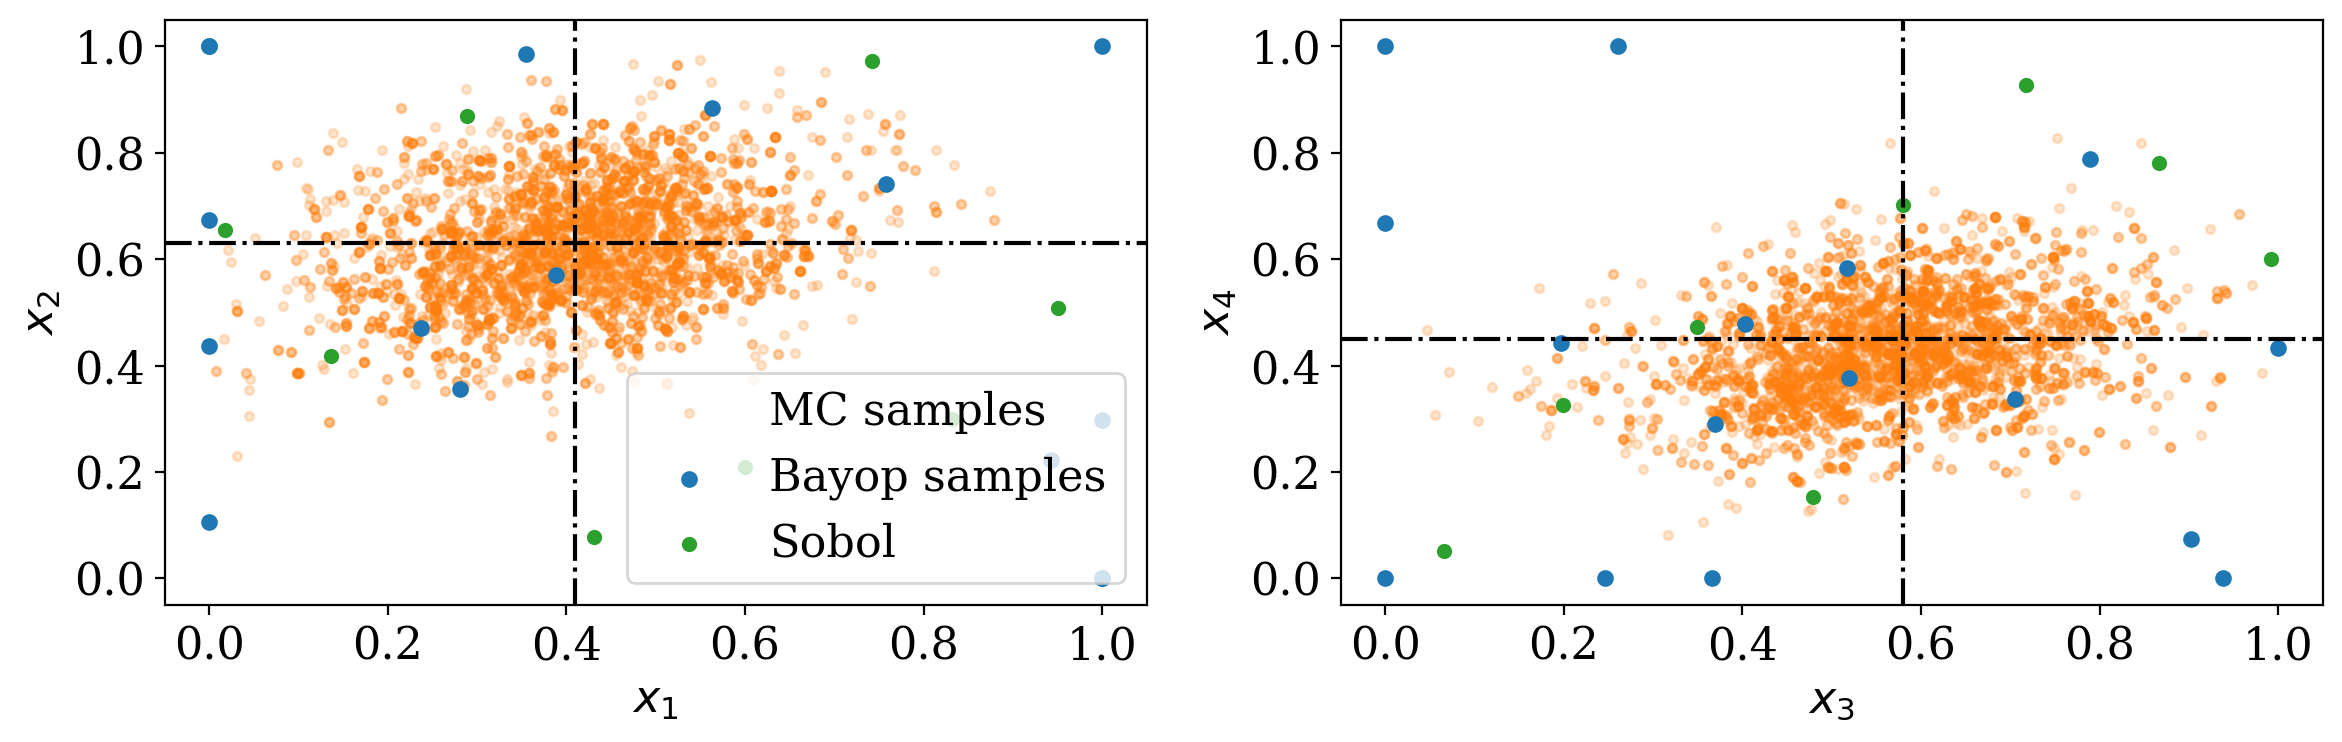

In [4]:
fig,ax = plt.subplots(1,int(ndim/2),figsize=(12,4))
for i,x in enumerate(ax):
    x.scatter(samples[:,2*i],samples[:,2*i+1],s=10,label='MC samples',color='C1',alpha=0.2)
    x.scatter(train_x[ninit:,2*i],train_x[ninit:,2*i+1],s=25,label='Bayop samples',color='C0')
    x.scatter(train_x[:ninit,2*i],train_x[:ninit,2*i+1],s=20,label='Sobol',color='C2')
    x.set_ylabel(r'$x_{{%i}}$'%(2*i+2))
    x.set_xlabel(r'$x_{{{}}}$'.format(2*i+1))
    x.axvline(f_mean[2*i],ls='-.',color='k')
    x.axhline(f_mean[2*i + 1],ls='-.',color='k')
ax[0].legend()
fig.tight_layout()
plt.savefig('EI_points.pdf')

In [5]:
samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.01,num_samples_equal=3000,difficult_model=True)
print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))

INFO:[NS]: Nested Sampling took 7.74s
INFO:[NS]: jaxns did 435332 likelihood evaluations


LogZ logz_mean: -0.2024, dlogz: 0.1470, 


Removed no burn in
Removed no burn in


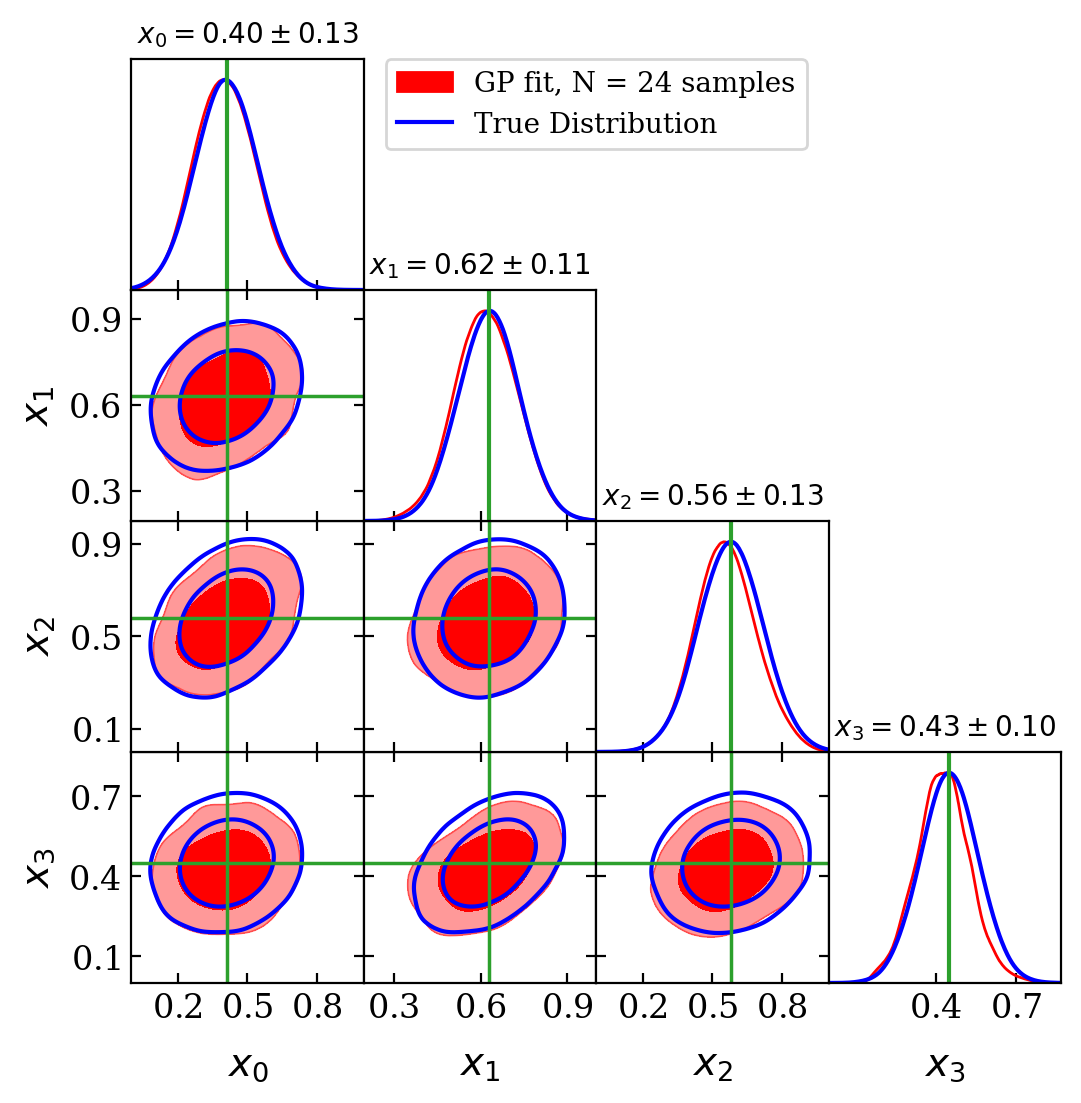

In [6]:
test_samples = np.random.multivariate_normal(mean=f_mean,cov=cov,size=int(1e5))
labels = [r"x_{0}".format(i) for i in range(ndim)]
names = [r"x_{0}".format(i) for i in range(ndim)]
ranges =  np.array(ndim*[[0,1]])
true_samples = MCSamples(samples=test_samples,names=names, labels = labels,ranges=ranges) # a comparison run
gp_samples = MCSamples(samples=samples[::4],names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=1.5,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 18
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 14
g.settings.title_limit_fontsize = 14
g.triangle_plot([gp_samples,true_samples], names,filled=[True,False],contour_colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} samples','True Distribution'],
                                contour_lws=[1,1.5],markers = dict(zip(names,f_mean)),
                                marker_args={'lw': 1.25, 'ls': '-', 'color': 'C2'},title_limit=1 ) # type: ignore

for i in range(ndim):
    ax = g.subplots[i,i]
    ax.axvline(f_mean[i], color='C2', ls='-')




### IPV test

[[0.01795472 0.0032797  0.00629377 0.00188088]
 [0.0032797  0.01140048 0.00206096 0.00450058]
 [0.00629377 0.00206096 0.0193845  0.00201846]
 [0.00188088 0.00450058 0.00201846 0.01147207]]
(8, 4) (8, 1)
Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:01<00:00, 986.83it/s, 7 steps of size 2.72e-01. acc. prob=0.86] 
INFO:[GP]: MCMC elapsed time: 1.39s



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]     19.58     34.61      2.38      0.08     79.90     30.59      0.97
_kernel_inv_length_sq[1]     26.69     70.96      2.65      0.18     59.81     41.99      1.03
_kernel_inv_length_sq[2]    105.53    554.98      1.45      0.18     19.21     34.50      1.00
_kernel_inv_length_sq[3]      5.02     18.61      1.12      0.09      3.60     35.94      1.00
        kernel_length[0]      0.94      1.59      0.52      0.07      1.50     36.22      1.04
        kernel_length[1]      0.91      1.84      0.44      0.04      1.55     31.85      0.99
        kernel_length[2]      1.07      1.20      0.55      0.04      2.46     33.10      1.06
        kernel_length[3]      1.42      1.24      1.09      0.08      3.58     99.00      1.00
            kernel_tausq      3.45      7.35      1.54      0.05      6.10     36.12      1.04
              kernel_var      6.53      5.65     

Text(0, 0.5, '$x_4$')

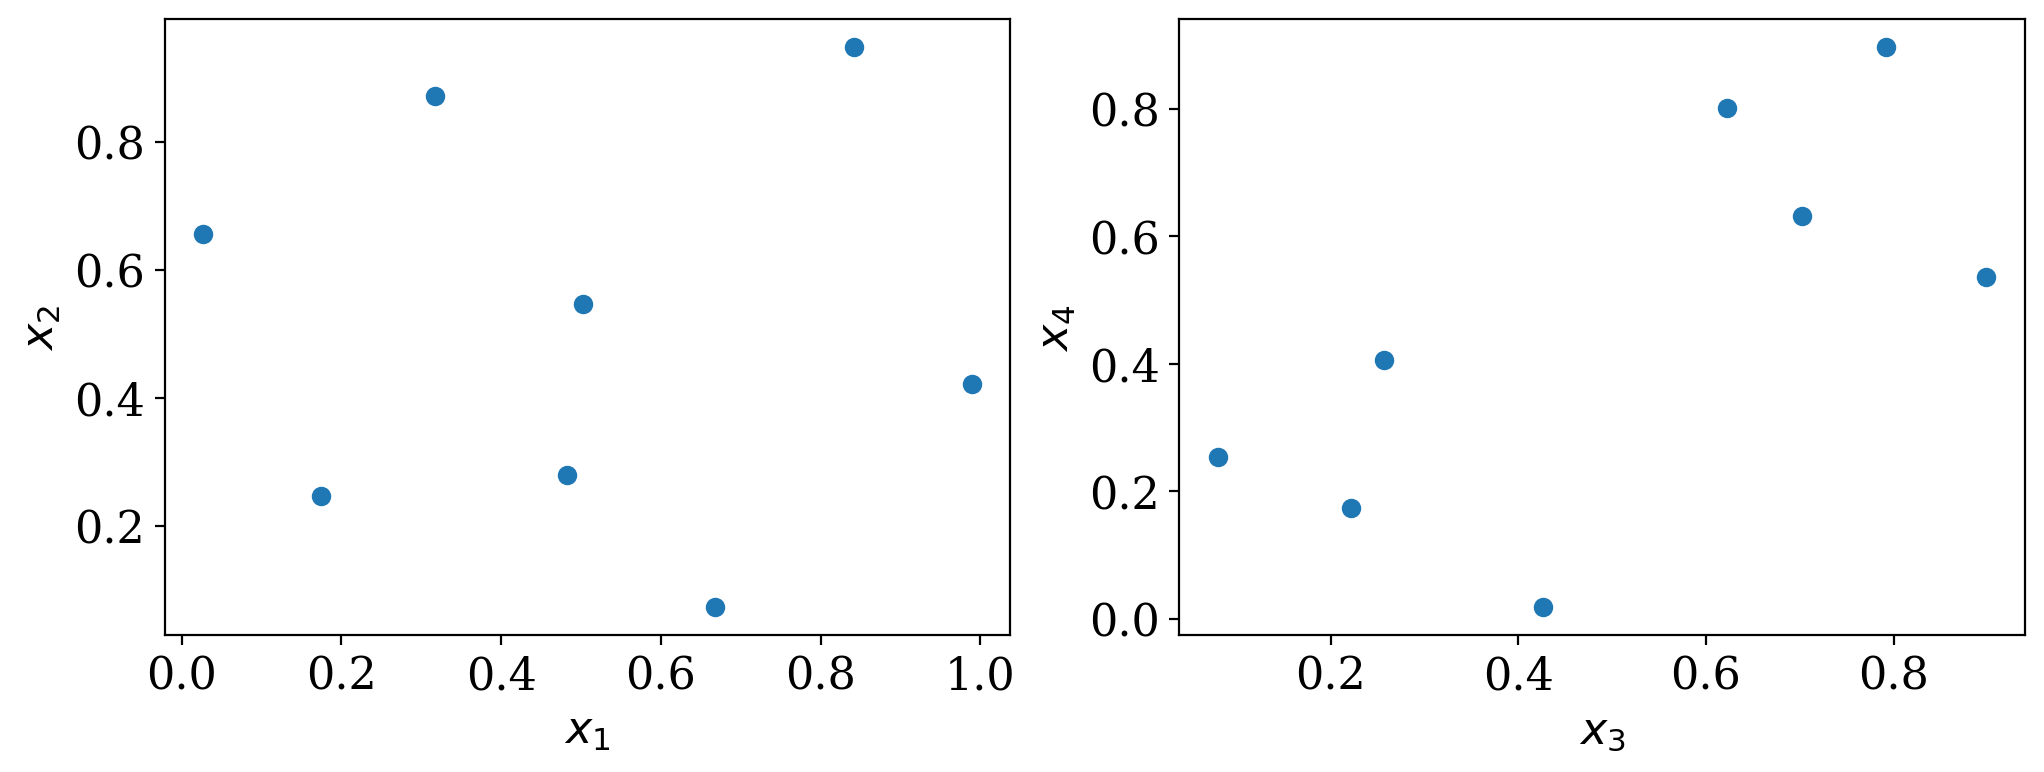

In [7]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 8
ndim = 4
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)
f_mean = np.array([0.41,0.63,0.58,0.45])[:ndim]
cov1 = 0.1*np.eye(ndim) + 0.2*np.random.uniform(0.,0.5,(ndim,ndim))
cov = 0.05*(cov1 + np.transpose(cov1))
print(cov)

from scipy.stats import multivariate_normal

mnorm =  multivariate_normal(mean = f_mean,cov = cov)

f = lambda x: mnorm.logpdf(x).reshape(-1,1) # -0.5*np.sum((x - f_mean)**2,axis=-1,keepdims=True)/ f_std**2 

train_y = f(train_x)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-6)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.scatter(train_x[:,0],train_x[:,1])
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
ax2.scatter(train_x[:,2],train_x[:,3])
ax2.set_xlabel(r'$x_3$')
ax2.set_ylabel(r'$x_4$')

In [8]:
nsteps = 16 # 32
mc_points_size = 16
start = time.time()
for i in range(nsteps):
    samples, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
    print(f"LogZ info :"+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
    size = len(samples)
    mc_points = samples[::int(size/mc_points_size),:]
    # print(mc_points.shape)
    acq_func = IPV(gp,mc_points)
    grad_fn = grad(acq_func)
    # print(ndim)
    x0 =  np.random.uniform(0,1,ndim)
    # print(x0.shape)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/4,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    # next_val = results.fun 
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x = jnp.atleast_2d(results.x)
    next_y = f((next_x)) 
    # print(next_y.shape)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    seed = i
    rng_key, _ = random.split(random.PRNGKey(seed), 2)
    gp.update(next_x,next_y,rng_key)
    # gp = saas_fbgp(train_x,train_y,noise=1e-6)
    # gp.fit(rng_key,warmup_steps=256,num_samples=256,thinning=16,verbose=False) # change rng key?
    print(f"----------------------Step {i+1} complete----------------------\n")


print(f"BO took {time.time() - start:.2f} s ")

INFO:[NS]: Nested Sampling took 3.89s
INFO:[NS]: jaxns did 35558 likelihood evaluations


LogZ info :logz_mean: = -4.6670, dlogz: = 0.2468, 


INFO:[AQ]: Acquisition optimization took 5.84 s


Next point at x = [0.41664693 0.6416335  0.30965278 0.7032947 ] with acquisition function value = 0.5175964663579707


sample: 100%|██████████| 384/384 [00:00<00:00, 433.11it/s, 7 steps of size 3.82e-01. acc. prob=0.86] 
INFO:[GP]: MCMC elapsed time: 1.10s


----------------------Step 1 complete----------------------



INFO:[NS]: Nested Sampling took 2.27s
INFO:[NS]: jaxns did 31184 likelihood evaluations


LogZ info :logz_mean: = -3.8685, dlogz: = 0.2457, 


INFO:[AQ]: Acquisition optimization took 2.56 s


Next point at x = [0.29615951 0.58110763 0.33609863 0.26662094] with acquisition function value = 0.21697013208774113


sample: 100%|██████████| 384/384 [00:00<00:00, 490.76it/s, 7 steps of size 4.90e-01. acc. prob=0.88] 
INFO:[GP]: MCMC elapsed time: 1.02s


----------------------Step 2 complete----------------------



INFO:[NS]: Nested Sampling took 2.09s
INFO:[NS]: jaxns did 16289 likelihood evaluations


LogZ info :logz_mean: = -0.9572, dlogz: = 0.2652, 


INFO:[AQ]: Acquisition optimization took 2.20 s


Next point at x = [0.09221904 0.49561106 0.05703    0.18692414] with acquisition function value = 0.04409893848996076


sample: 100%|██████████| 384/384 [00:00<00:00, 400.38it/s, 7 steps of size 2.45e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 1.32s


----------------------Step 3 complete----------------------



INFO:[NS]: Nested Sampling took 2.14s
INFO:[NS]: jaxns did 21709 likelihood evaluations


LogZ info :logz_mean: = -1.0487, dlogz: = 0.2651, 


INFO:[AQ]: Acquisition optimization took 3.23 s


Next point at x = [0.45120165 0.59836353 0.84968664 0.0701718 ] with acquisition function value = 0.20954938811812676


sample: 100%|██████████| 384/384 [00:00<00:00, 468.44it/s, 15 steps of size 3.42e-01. acc. prob=0.89]
INFO:[GP]: MCMC elapsed time: 1.04s


----------------------Step 4 complete----------------------



INFO:[NS]: Nested Sampling took 2.22s
INFO:[NS]: jaxns did 34326 likelihood evaluations


LogZ info :logz_mean: = -3.3138, dlogz: = 0.2593, 


INFO:[AQ]: Acquisition optimization took 3.81 s


Next point at x = [0.28870011 0.56183199 0.59673309 0.3133589 ] with acquisition function value = 0.15149701581154706


sample: 100%|██████████| 384/384 [00:00<00:00, 470.36it/s, 31 steps of size 1.80e-01. acc. prob=0.96]
INFO:[GP]: MCMC elapsed time: 1.05s


----------------------Step 5 complete----------------------



INFO:[NS]: Nested Sampling took 2.77s
INFO:[NS]: jaxns did 33525 likelihood evaluations


LogZ info :logz_mean: = -1.8078, dlogz: = 0.2754, 


INFO:[AQ]: Acquisition optimization took 2.89 s


Next point at x = [0.17780418 0.47663353 0.51173144 0.20879967] with acquisition function value = 0.06324731454461979


sample: 100%|██████████| 384/384 [00:00<00:00, 486.84it/s, 11 steps of size 4.07e-01. acc. prob=0.87]
INFO:[GP]: MCMC elapsed time: 1.00s


----------------------Step 6 complete----------------------



INFO:[NS]: Nested Sampling took 2.17s
INFO:[NS]: jaxns did 30851 likelihood evaluations


LogZ info :logz_mean: = -1.5828, dlogz: = 0.2733, 


INFO:[AQ]: Acquisition optimization took 3.91 s


Next point at x = [0.45097062 0.53224857 0.48222729 0.36828351] with acquisition function value = 0.03604401094664177


sample: 100%|██████████| 384/384 [00:00<00:00, 464.22it/s, 7 steps of size 2.69e-01. acc. prob=0.86] 
INFO:[GP]: MCMC elapsed time: 1.04s


----------------------Step 7 complete----------------------



INFO:[NS]: Nested Sampling took 2.22s
INFO:[NS]: jaxns did 32706 likelihood evaluations


LogZ info :logz_mean: = -0.8934, dlogz: = 0.2726, 


INFO:[AQ]: Acquisition optimization took 3.52 s


Next point at x = [0.43128393 0.71502406 0.53409254 0.53963454] with acquisition function value = 0.02246860310276759


sample: 100%|██████████| 384/384 [00:00<00:00, 479.48it/s, 7 steps of size 5.47e-01. acc. prob=0.83]
INFO:[GP]: MCMC elapsed time: 1.04s


----------------------Step 8 complete----------------------



INFO:[NS]: Nested Sampling took 2.14s
INFO:[NS]: jaxns did 27825 likelihood evaluations


LogZ info :logz_mean: = -0.0087, dlogz: = 0.2610, 


INFO:[AQ]: Acquisition optimization took 4.86 s


Next point at x = [0.30384138 0.74301505 0.52006281 0.44968278] with acquisition function value = 0.00898407407557802


sample: 100%|██████████| 384/384 [00:00<00:00, 485.82it/s, 15 steps of size 3.11e-01. acc. prob=0.94]
INFO:[GP]: MCMC elapsed time: 1.02s


----------------------Step 9 complete----------------------



INFO:[NS]: Nested Sampling took 2.22s
INFO:[NS]: jaxns did 27763 likelihood evaluations


LogZ info :logz_mean: = -0.1179, dlogz: = 0.2649, 


INFO:[AQ]: Acquisition optimization took 2.80 s


Next point at x = [0.39209677 0.67468284 0.72268844 0.52876106] with acquisition function value = 0.009191987548827527


sample: 100%|██████████| 384/384 [00:00<00:00, 491.83it/s, 7 steps of size 5.39e-01. acc. prob=0.93]
INFO:[GP]: MCMC elapsed time: 0.99s


----------------------Step 10 complete----------------------



INFO:[NS]: Nested Sampling took 2.19s
INFO:[NS]: jaxns did 29070 likelihood evaluations


LogZ info :logz_mean: = -0.0346, dlogz: = 0.2606, 


INFO:[AQ]: Acquisition optimization took 2.38 s


Next point at x = [0.565837   0.87459821 0.78846354 0.52377112] with acquisition function value = 0.009140519231232639


sample: 100%|██████████| 384/384 [00:00<00:00, 496.38it/s, 15 steps of size 3.39e-01. acc. prob=0.95]
INFO:[GP]: MCMC elapsed time: 0.99s


----------------------Step 11 complete----------------------



INFO:[NS]: Nested Sampling took 2.83s
INFO:[NS]: jaxns did 29059 likelihood evaluations


LogZ info :logz_mean: = -0.1203, dlogz: = 0.2656, 


INFO:[AQ]: Acquisition optimization took 5.52 s


Next point at x = [0.23494518 0.51340778 0.4986193  0.4146068 ] with acquisition function value = 0.002480340247497298


sample: 100%|██████████| 384/384 [00:00<00:00, 479.91it/s, 7 steps of size 6.00e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 1.03s


----------------------Step 12 complete----------------------



INFO:[NS]: Nested Sampling took 2.24s
INFO:[NS]: jaxns did 28751 likelihood evaluations


LogZ info :logz_mean: = 0.1184, dlogz: = 0.2594, 


INFO:[AQ]: Acquisition optimization took 3.50 s


Next point at x = [0.27616461 0.69357028 0.32814157 0.42901398] with acquisition function value = 0.0011480776184495285


sample: 100%|██████████| 384/384 [00:00<00:00, 406.37it/s, 7 steps of size 5.00e-01. acc. prob=0.93]
INFO:[GP]: MCMC elapsed time: 1.19s


----------------------Step 13 complete----------------------



INFO:[NS]: Nested Sampling took 2.24s
INFO:[NS]: jaxns did 28635 likelihood evaluations


LogZ info :logz_mean: = 0.0789, dlogz: = 0.2632, 


INFO:[AQ]: Acquisition optimization took 3.02 s


Next point at x = [0.60130019 0.63729844 0.60599608 0.34723516] with acquisition function value = 0.00040172280512486627


sample: 100%|██████████| 384/384 [00:00<00:00, 496.96it/s, 7 steps of size 6.72e-01. acc. prob=0.91]
INFO:[GP]: MCMC elapsed time: 1.01s


----------------------Step 14 complete----------------------



INFO:[NS]: Nested Sampling took 2.31s
INFO:[NS]: jaxns did 25947 likelihood evaluations


LogZ info :logz_mean: = 0.2255, dlogz: = 0.2579, 


INFO:[AQ]: Acquisition optimization took 2.58 s


Next point at x = [0.61453887 0.63361149 0.9122127  0.44867579] with acquisition function value = 0.0004815292995275118


sample: 100%|██████████| 384/384 [00:00<00:00, 492.03it/s, 7 steps of size 6.85e-01. acc. prob=0.91] 
INFO:[GP]: MCMC elapsed time: 1.00s


----------------------Step 15 complete----------------------



INFO:[NS]: Nested Sampling took 2.44s
INFO:[NS]: jaxns did 29532 likelihood evaluations


LogZ info :logz_mean: = 0.0807, dlogz: = 0.2628, 


INFO:[AQ]: Acquisition optimization took 4.34 s


Next point at x = [0.6576141  0.74999726 0.7027341  0.376484  ] with acquisition function value = 0.0003066222636746302


sample: 100%|██████████| 384/384 [00:00<00:00, 506.31it/s, 3 steps of size 6.11e-01. acc. prob=0.92]
INFO:[GP]: MCMC elapsed time: 0.98s


----------------------Step 16 complete----------------------

BO took 113.34 s 


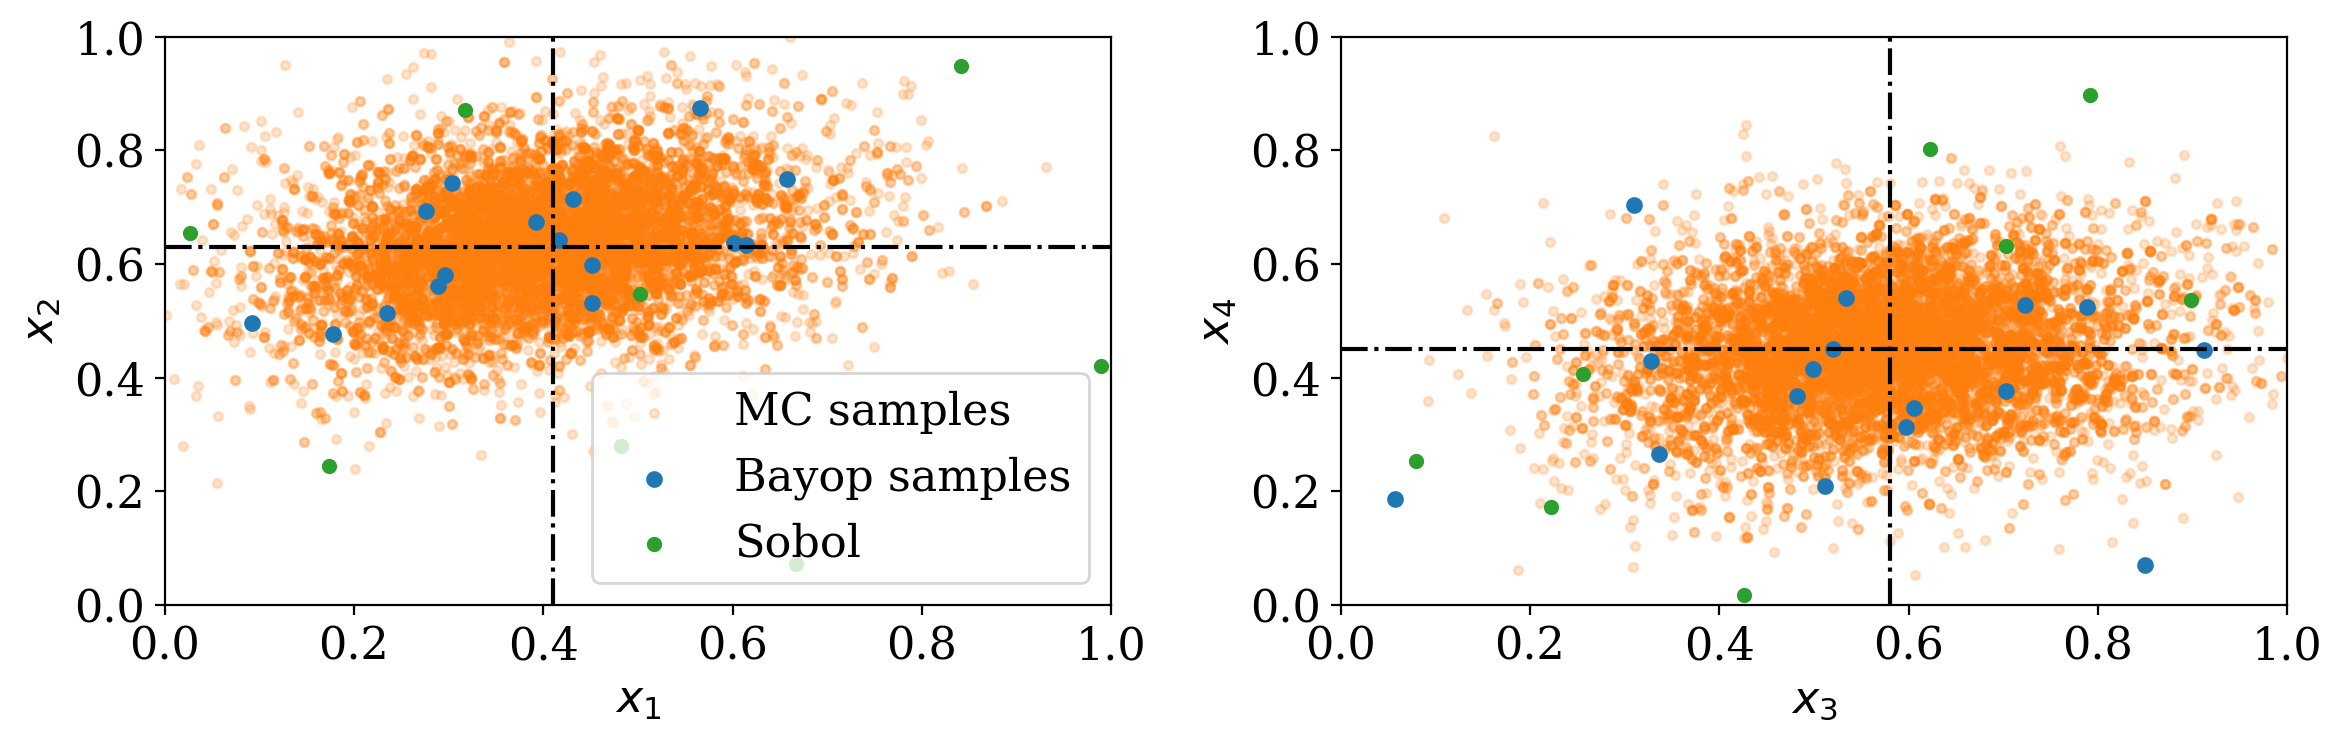

In [13]:
fig,ax = plt.subplots(1,int(ndim/2),figsize=(12,4))
for i,x in enumerate(ax):
    x.scatter(samples[:,2*i],samples[:,2*i+1],s=10,label='MC samples',color='C1',alpha=0.2)
    x.scatter(train_x[ninit:,2*i],train_x[ninit:,2*i+1],s=25,label='Bayop samples',color='C0')
    x.scatter(train_x[:ninit,2*i],train_x[:ninit,2*i+1],s=20,label='Sobol',color='C2')
    x.set_ylabel(r'$x_{{%i}}$'%(2*i+2))
    x.set_xlabel(r'$x_{{{}}}$'.format(2*i+1))
    x.axvline(f_mean[2*i],ls='-.',color='k')
    x.axhline(f_mean[2*i + 1],ls='-.',color='k')
    x.set_ylim(0,1)
    x.set_xlim(0,1)
ax[0].legend()
fig.tight_layout()
plt.savefig('WIPV_points.pdf')

In [10]:
samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.01,num_samples_equal=3000,difficult_model=True)
print(f"LogZ info: "+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))

INFO:[NS]: Nested Sampling took 7.45s
INFO:[NS]: jaxns did 427239 likelihood evaluations


LogZ info: logz_mean: = 0.0130, dlogz: = 0.1470, 


Removed no burn in
Removed no burn in


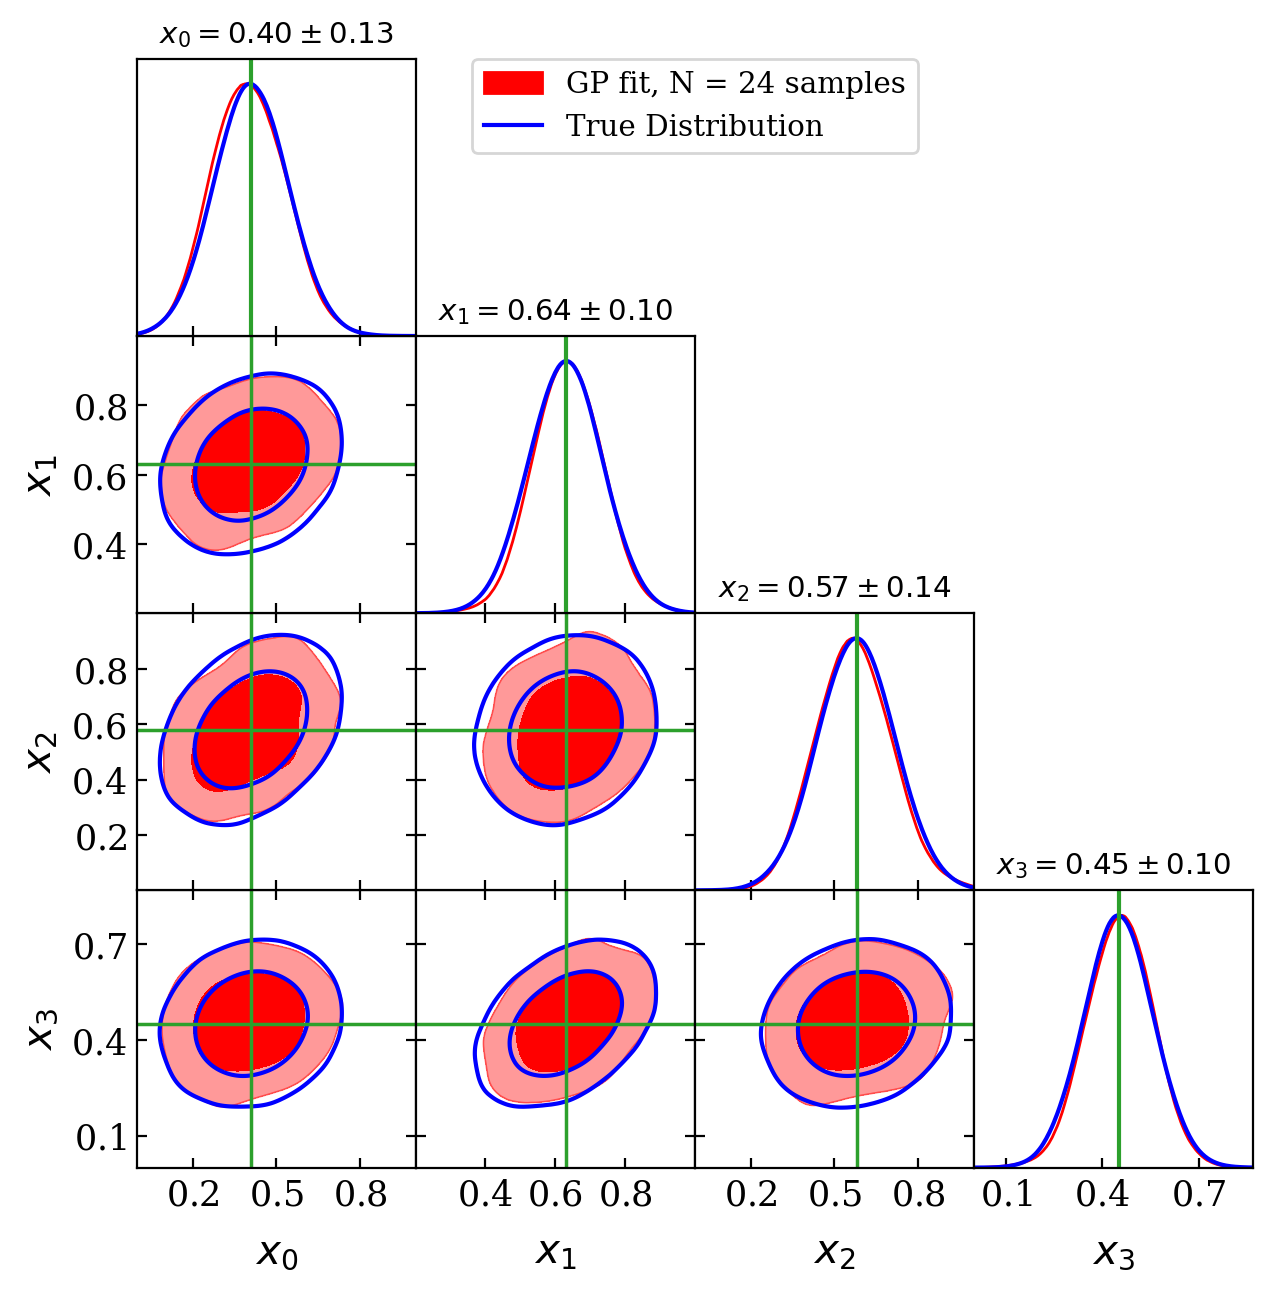

In [11]:
test_samples = np.random.multivariate_normal(mean=f_mean,cov=cov,size=int(1e5))
labels = [r"x_{0}".format(i) for i in range(ndim)]
names = [r"x_{0}".format(i) for i in range(ndim)]
ranges =  np.array(ndim*[[0,1]])
true_samples = MCSamples(samples=test_samples,names=names, labels = labels,ranges=ranges) # a comparison run
gp_samples = MCSamples(samples=samples[::4],names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=1.8,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 18
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 14
g.settings.title_limit_fontsize = 14
g.triangle_plot([gp_samples,true_samples], names,filled=[True,False],contour_colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} samples','True Distribution'],
                                contour_lws=[1,1.5],markers = dict(zip(names,f_mean)),
                                marker_args={'lw': 1.25, 'ls': '-', 'color': 'C2'},title_limit=1 ) # type: ignore

for i in range(ndim):
    ax = g.subplots[i,i]
    ax.axvline(f_mean[i], color='C2', ls='-')

# for ax in g.subplots[:,0]:
#     ax.axvline(, color='C2', ls='-')
# IPython.display.display(g.fig)

